In [1]:
import time
import datetime
import torch
import random
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import scale

In [2]:
# для воспроизводимости эксперимента:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
timesample = 0.004
start_time = 1.0
end_time = 2.0
n_receivers = 80
n_timesamples = int((end_time - start_time)/timesample)

data = np.empty([1,2,n_receivers,n_timesamples])

In [4]:
n_models = 1100

for i in range(n_models):
    if (i+1) % 100 == 0:
        print(i+1,'/',n_models)
    data_Z = pd.read_csv('csv_models_crack_density_Z\\model_{}.csv'.format(i+1))
    model_gather_Z = np.array(data_Z[data_Z.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    data_X = pd.read_csv('csv_models_crack_density_X\\model_{}.csv'.format(i+1))
    model_gather_X = np.array(data_X[data_X.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    model_gather = np.vstack(([model_gather_Z],[model_gather_X]))
    model_gather = np.reshape(model_gather,(1,2,n_receivers,n_timesamples))
    
    data = np.vstack((data,model_gather))
    
data = data[1:]

100 / 1100
200 / 1100
300 / 1100
400 / 1100
500 / 1100
600 / 1100
700 / 1100
800 / 1100
900 / 1100
1000 / 1100
1100 / 1100


In [5]:
print(data.shape)
print(data[0])

(1100, 2, 80, 250)
[[[ 8.00617505e-04  1.02273724e-03  1.32891117e-03 ...  7.55271685e-06
    4.02872138e-06  5.54585586e-06]
  [ 8.12600134e-04  1.03973970e-03  1.34946941e-03 ...  1.83841039e-05
    1.61839998e-05  1.07307305e-05]
  [ 8.08924204e-04  1.03607518e-03  1.34817208e-03 ...  2.20412476e-05
    1.66781392e-05  1.50394571e-05]
  ...
  [ 1.56030874e-05  4.26389597e-05  6.87852298e-05 ...  4.40955535e-03
    3.73170828e-03 -1.93199632e-03]
  [-9.79333854e-05 -1.42892852e-04 -2.08559941e-04 ... -7.42730498e-03
   -3.09128850e-03  2.96215597e-03]
  [-3.46126268e-04 -5.30554680e-04 -6.34867465e-04 ...  4.74087521e-03
   -3.35848751e-03 -7.05462322e-03]]

 [[ 6.99237135e-05  8.44761380e-05  9.41588223e-05 ... -3.16790974e-05
   -4.79095761e-05 -4.99428861e-05]
  [ 5.52923593e-05  5.61278430e-05  7.12123438e-05 ...  1.61299686e-05
   -2.66639108e-05 -7.83016876e-05]
  [ 3.67287139e-05  4.03100275e-05  4.04187740e-05 ... -3.74700721e-06
   -1.70057610e-05  2.99470703e-05]
  ...
  [ 

In [6]:
# центрирование и нормализация данных
for i in range(n_models):
    for j in range(2):
        data[i,j] = scale(data[i,j], axis=1)

print(data[0])

[[[ 1.53621181e-02  1.97431569e-02  2.57820613e-02 ... -2.80110109e-04
   -3.49616589e-04 -3.19692976e-04]
  [ 1.61391646e-02  2.07631765e-02  2.70685240e-02 ... -2.91518528e-05
   -7.39406476e-05 -1.84956014e-04]
  [ 1.68832980e-02  2.17099586e-02  2.83416090e-02 ...  1.63065969e-04
    4.91069422e-05  1.42870947e-05]
  ...
  [ 6.10024535e-04  1.78496977e-03  2.92125400e-03 ...  1.91565700e-01
    1.62107313e-01 -8.40302124e-02]
  [-3.48904257e-03 -5.45298574e-03 -8.32149023e-03 ... -3.23654526e-01
   -1.34246363e-01  1.30183398e-01]
  [-1.39971988e-02 -2.20915981e-02 -2.66697937e-02 ...  2.09266781e-01
   -1.46207060e-01 -3.08427176e-01]]

 [[ 1.25165901e-02  1.61046107e-02  1.84919566e-02 ... -1.25344231e-02
   -1.65361819e-02 -1.70375113e-02]
  [ 7.36114401e-03  7.51558306e-03  1.03039511e-02 ...  1.21981047e-04
   -7.78846213e-03 -1.73336986e-02]
  [ 3.97687768e-03  4.52674785e-03  4.54344464e-03 ... -2.23771105e-03
   -4.27344260e-03  2.93563309e-03]
  ...
  [ 1.98903394e-02  1.2

In [22]:
frac_params = pd.read_csv('frac_params_crack_density.csv')
frac_params = np.array(frac_params[['aspect_ratio1']] * 1000)

In [23]:
X_train = torch.Tensor(data[:800])
X_validation = torch.Tensor(data[800:1100])

Y_train = torch.Tensor(frac_params[:800])
Y_validation = torch.Tensor(frac_params[800:1100])

In [24]:
# изменил кол-во нейронов в полносвязных слоях
class FracAnisotropyNet(torch.nn.Module):
    def __init__(self,n1,n2,n3,n4,prob=0.0):
        super(FracAnisotropyNet,self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=n1, kernel_size=(2,4), padding=0, stride=2)
        self.ac1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=n1)
        self.do1 = torch.nn.Dropout(p=prob)
        #self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=2, padding=0, stride=(1,2))
        self.ac2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=n2)
        self.do2 = torch.nn.Dropout(p=prob)
        
        self.conv3 = torch.nn.Conv2d(in_channels=n2, out_channels=n3, kernel_size=(2,3), padding=1, stride=(1,2))
        self.ac3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=n3)
        self.do3 = torch.nn.Dropout(p=prob)
        
        self.conv4 = torch.nn.Conv2d(in_channels=n3, out_channels=n4, kernel_size=2, padding=0, stride=2)
        self.ac4 = torch.nn.ReLU()
        self.bn4 = torch.nn.BatchNorm2d(num_features=n4)
        self.do4 = torch.nn.Dropout(p=prob)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=(2,1), stride=(2,1))
        
        self.fc1 = torch.nn.Linear(10*15*n4,200)
        self.ac1_ = torch.nn.Tanh()
        #self.bn1_ = torch.nn.BatchNorm1d(num_features=100)
        self.fc2 = torch.nn.Linear(200,80)
        self.ac2_ = torch.nn.Tanh()
        #self.bn2_ = torch.nn.BatchNorm1d(num_features=40)
        self.fc3 = torch.nn.Linear(80,20)
        self.ac3_ = torch.nn.Tanh()
        
        self.out = torch.nn.Linear(20,1) 
        
    def forward(self,x):
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv1(x)
        x = self.ac1(x)
        x = self.bn1(x)
        x = self.do1(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        x = self.do2(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv3(x)
        x = self.ac3(x)
        x = self.bn3(x)
        x = self.do3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        #x = self.pool3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv4(x)
        x = self.ac4(x)
        x = self.bn4(x)
        x = self.do4(x)
        x = self.pool4(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.ac1_(x)
        #x = self.bn1_(x)
        x = self.fc2(x)
        x = self.ac2_(x)
        #x = self.bn2_(x)
        x = self.fc3(x)
        x = self.ac3_(x)
            
        x = self.out(x)
        
        return x

In [25]:
device = torch.device('cpu')

neural_net = FracAnisotropyNet(4,6,4,2)
neural_net = neural_net.to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(neural_net.parameters(), lr=3.0e-4)

In [26]:
batch_size = 100
N = len(X_train)

test_loss_history = []
train_loss_history = []

X_validation = X_validation.to(device)
Y_validation = Y_validation.to(device)

start_time = datetime.datetime.now()
epochs = 200

for epoch in range(epochs):
    order = np.random.permutation(N)
  
    loss_sum = 0.0
    for batch_init in range(0,N,batch_size):
        optimizer.zero_grad()
        neural_net.train()
    
        X_batch = X_train[order[batch_init:batch_init+batch_size]].to(device)
        y_batch = Y_train[order[batch_init:batch_init+batch_size]].to(device)
    
        pred = neural_net.forward(X_batch)
        #loss_value = weighted_loss(pred,y_batch)
        loss_value = loss(pred,y_batch)
        loss_sum += loss_value
        loss_value.backward()
    
        optimizer.step()
    
    neural_net.eval()
    pred = neural_net.forward(X_validation)
  
    tr_l = loss_sum/(N/batch_size)
    te_l = loss(pred,Y_validation)
    train_loss_history.append(tr_l.data.cpu())
    test_loss_history.append(te_l.data.cpu())
  
    print('epoch #', epoch+1,':\n\tTrain Loss:\t',tr_l.data.cpu().numpy(),'\n\tTest Loss:\t',te_l.data.cpu().numpy())

educ_time = datetime.datetime.now() - start_time
print('Time elapsed:', educ_time)

epoch # 1 :
	Train Loss:	 0.2611096 
	Test Loss:	 0.5628438
epoch # 2 :
	Train Loss:	 0.112842746 
	Test Loss:	 0.37408325
epoch # 3 :
	Train Loss:	 0.07437951 
	Test Loss:	 0.22261661
epoch # 4 :
	Train Loss:	 0.07603273 
	Test Loss:	 0.09449668
epoch # 5 :
	Train Loss:	 0.070120856 
	Test Loss:	 0.06945755
epoch # 6 :
	Train Loss:	 0.0695842 
	Test Loss:	 0.070293024
epoch # 7 :
	Train Loss:	 0.06889674 
	Test Loss:	 0.06991312
epoch # 8 :
	Train Loss:	 0.06791513 
	Test Loss:	 0.06943498
epoch # 9 :
	Train Loss:	 0.068668894 
	Test Loss:	 0.06930642
epoch # 10 :
	Train Loss:	 0.06890808 
	Test Loss:	 0.06936792
epoch # 11 :
	Train Loss:	 0.06818517 
	Test Loss:	 0.069527894
epoch # 12 :
	Train Loss:	 0.06806903 
	Test Loss:	 0.069170125
epoch # 13 :
	Train Loss:	 0.067895345 
	Test Loss:	 0.06910576
epoch # 14 :
	Train Loss:	 0.0678862 
	Test Loss:	 0.06921942
epoch # 15 :
	Train Loss:	 0.06805816 
	Test Loss:	 0.06908402
epoch # 16 :
	Train Loss:	 0.06783569 
	Test Loss:	 0.0690606

KeyboardInterrupt: 

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
num = 10
def moving_average(a, n=num): # среднее скользящее среднее
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

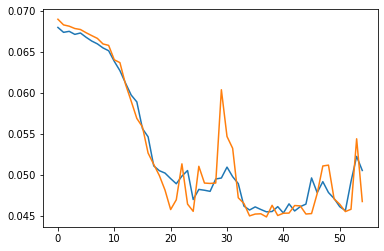

In [18]:
plt.plot(train_loss_history[5:])
plt.plot(test_loss_history[5:])

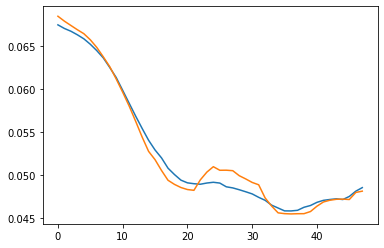

In [19]:
avg_loss_train = moving_average(train_loss_history)
avg_loss_test = moving_average(test_loss_history)
plt.plot(avg_loss_train[3:])
plt.plot(avg_loss_test[3:])

In [20]:
pred = neural_net.forward(X_validation)
pred = pred.data.cpu().numpy()
y_val = Y_validation.data.cpu().numpy()
print('Predicted\tReal value\tDifference')
sum_e1_n = 0.0
sum_e1_t = 0.0
sum_asp = 0.0
sum_asp_real = 0.0
sum_e1_n_real = 0.0
sum_e1_t_real = 0.0
for i in range(300):
    dif = abs(pred[i]-y_val[i])
    print(pred[i],'\t',y_val[i],'\t',dif)
    #sum_e1_n += dif[0]
    #sum_e1_t += dif[1]
    sum_asp += dif[0]
    sum_asp_real += y_val[i][0]
    #sum_e1_n_real += y_val[i][0]
    #sum_e1_t_real += y_val[i][1]
    
mean_asp_real = sum_asp_real/300
#mean_e1_n_real = sum_e1_n_real/300
#mean_e1_t_real = sum_e1_t_real/300

Predicted	Real value	Difference
[0.38566867] 	 [0.7924522] 	 [0.40678355]
[0.59688354] 	 [0.9685193] 	 [0.37163574]
[0.42432204] 	 [0.9745007] 	 [0.55017865]
[0.44083676] 	 [0.48122782] 	 [0.04039106]
[0.48629445] 	 [0.2022952] 	 [0.28399926]
[0.36725244] 	 [0.5581958] 	 [0.19094339]
[0.65289205] 	 [0.88674504] 	 [0.23385298]
[0.55097] 	 [0.7094475] 	 [0.15847749]
[0.36992648] 	 [0.41045702] 	 [0.04053053]
[0.45814052] 	 [0.32622644] 	 [0.13191408]
[0.57115245] 	 [0.6864923] 	 [0.11533988]
[0.40304157] 	 [0.4649181] 	 [0.06187654]
[0.6143193] 	 [0.8324133] 	 [0.21809399]
[0.594935] 	 [0.78365576] 	 [0.18872076]
[0.48461455] 	 [0.38863495] 	 [0.0959796]
[0.47228637] 	 [0.42579874] 	 [0.04648763]
[0.5863645] 	 [0.34639654] 	 [0.23996797]
[0.48049852] 	 [0.46221521] 	 [0.01828331]
[0.45125574] 	 [0.45577013] 	 [0.0045144]
[0.40119836] 	 [0.40662217] 	 [0.00542381]
[0.60544944] 	 [0.51489204] 	 [0.0905574]
[0.48388165] 	 [0.88845885] 	 [0.4045772]
[0.39947292] 	 [0.13012354] 	 [0.2693494]


[0.6089003] 	 [0.9598841] 	 [0.3509838]
[0.828798] 	 [0.9134619] 	 [0.08466393]
[0.6211806] 	 [0.44786686] 	 [0.17331374]
[0.5365294] 	 [0.36797407] 	 [0.16855535]
[0.41914347] 	 [0.8511162] 	 [0.4319727]
[0.5499365] 	 [0.32975623] 	 [0.22018024]
[0.42819616] 	 [0.4981832] 	 [0.06998703]
[0.39173833] 	 [0.48984334] 	 [0.09810501]
[0.6499368] 	 [0.87664753] 	 [0.22671074]
[0.71415484] 	 [0.9899767] 	 [0.27582186]
[0.6692132] 	 [0.6106651] 	 [0.05854809]
[0.39112708] 	 [0.3530723] 	 [0.03805479]
[0.38502425] 	 [0.8195709] 	 [0.43454665]
[0.6265714] 	 [0.4102263] 	 [0.21634513]
[0.6970994] 	 [0.6405988] 	 [0.05650061]
[0.43084455] 	 [0.19267642] 	 [0.23816812]
[0.56337947] 	 [0.69413894] 	 [0.13075948]
[0.50151235] 	 [0.5485012] 	 [0.04698884]
[0.62009] 	 [0.68779284] 	 [0.06770283]
[0.6412131] 	 [0.8607783] 	 [0.21956515]
[0.4528355] 	 [0.7263473] 	 [0.27351183]
[0.4688265] 	 [0.37413186] 	 [0.09469464]
[0.5582208] 	 [0.53255206] 	 [0.02566874]
[0.4842436] 	 [0.31119215] 	 [0.17305145]
[

In [21]:
#print('Mean e1_n difference: ', sum_e1_n/300)
#print('Mean e1_t difference: ', sum_e1_t/300)
print('Mean aspect ratio difference: ', sum_asp/300)

print(mean_asp_real)
#print('\nRelative e1_n accuracy: ', sum_e1_n/300/mean_e1_n_real)
#print('Relative e1_t accuracy: ', sum_e1_t/300/mean_e1_t_real)
print('Relative aspect ratio accuracy: ', sum_asp/300/mean_asp_real)

Mean aspect ratio difference:  0.18163113872210185
0.5425847158829371
Relative aspect ratio accuracy:  0.33475166809027634
